<div style="border:solid orange 3px; padding: 16px">  
    <font size="4">  
        <p style="text-align: center;">
            <b> 7. Анализ бизнес-показателей. Аналитика в Яндекс.Афише </b>
        </p> 
    </font>
</div>

## 0. Описание проекта
Данные от сервиса Яндекс.Афиши с июня 2017 по конец мая 2018 года: лог сервера с данными о посещениях сайта, выгрузка всех заказов за этот период, статистика рекламных расходов.

Необходимо определить как посетители пользуются сайтом, когда начинают покупать, сколько денег приносят. Необходимо дать общие рекомендации маркетологам про платоформы и источники рекламы. 

## 1. Предобработка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#pd.set_option('display.max_columns', None)

path = 'C:/Users/pavel/Desktop/da/projects/datasets/'

In [2]:
# таблица visits (лог сервера с информацией о посещениях сайта)
visits = pd.read_csv(path + '07_afisha_visits_log.csv')

Описание данных:
- `Uid` — уникальный идентификатор пользователя;
- `Device` — категория устройства пользователя;
- `Start Ts` — дата и время начала сессии;
- `End Ts` — дата и время окончания сессии;
- `Source Id` — идентификатор рекламного источника, из которого пришел пользователь.

In [3]:
# переименуем столбцы
visits = visits.rename(columns = {"Uid"      : "uid", 
                                  "Device"   : "device",
                                  "Start Ts" : "start_ts",
                                  "End Ts"   : "end_ts",
                                  "Source Id": "source_id"})

In [4]:
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [5]:
visits.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

In [6]:
# изменим порядок столбцов
visits = visits[['start_ts', 'end_ts', 'device', 'source_id', 'uid']]

In [7]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
start_ts     359400 non-null object
end_ts       359400 non-null object
device       359400 non-null object
source_id    359400 non-null int64
uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [8]:
# приведем данные о начале и завершении сессии к типу даты
visits['start_ts'] =  pd.to_datetime(visits['start_ts'], format='%Y-%m-%d %H:%M')
visits['end_ts'] =  pd.to_datetime(visits['end_ts'], format='%Y-%m-%d %H:%M')

In [9]:
visits.head()

,start_ts,end_ts,device,source_id,uid
0,2017-12-20 17:20:00,2017-12-20 17:38:00,touch,4,16879256277535980062
1,2018-02-19 16:53:00,2018-02-19 17:21:00,desktop,2,104060357244891740
2,2017-07-01 01:54:00,2017-07-01 01:54:00,touch,5,7459035603376831527
3,2018-05-20 10:59:00,2018-05-20 11:23:00,desktop,9,16174680259334210214
4,2017-12-27 14:06:00,2017-12-27 14:06:00,desktop,3,9969694820036681168


In [10]:
# рассмотрим записи, у которых начало сессии после или совпадает с окончанием сессии
print(len(visits.query('start_ts >= end_ts')))

35796


In [11]:
# оставим только посещения с положительной длительностью
visits = visits.query('start_ts < end_ts')

In [12]:
visits['start_ts'].describe()

count                  323604
unique                 209770
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: start_ts, dtype: object

In [13]:
visits['end_ts'].describe()

count                  323604
unique                 210174
top       2017-11-24 16:51:00
freq                       22
first     2017-06-01 00:02:00
last      2018-06-01 01:26:00
Name: end_ts, dtype: object

In [14]:
# выведем количество полных дубликатов 
visits.duplicated().sum()

0

In [15]:
# выведем уникальные записи в столбце device и их количество 
visits['device'].value_counts()

desktop    238876
touch       84728
Name: device, dtype: int64

In [16]:
# выведем уникальные записи в столбце source_id и их количество 
visits['source_id'].value_counts()

4     90896
3     76584
5     59520
2     43468
1     32146
9     11979
10     8971
7        35
6         5
Name: source_id, dtype: int64

In [17]:
# исключим из рассмотрения посещения с рекламными источниками 6 и 7, 
# из-за их малого относительного количества (~ 0.01%)
visits = visits.query('source_id not in [6, 7]')

In [18]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323564 entries, 0 to 359399
Data columns (total 5 columns):
start_ts     323564 non-null datetime64[ns]
end_ts       323564 non-null datetime64[ns]
device       323564 non-null object
source_id    323564 non-null int64
uid          323564 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 14.8+ MB


In [19]:
# количество уникальных пользователей за всё время (июнь 2017 - май 2018)
len(visits['uid'].value_counts())

207022

Всего 207.022 пользователя с 323.564 сессиями.

---

In [20]:
# таблица orders (информация о заказах)
orders = pd.read_csv(path + '07_afisha_orders_log.csv')

Описание данных:
- `Uid` — уникальный id пользователя, который сделал заказ;
- `Buy Ts` — дата и время заказа;
- `Revenue` — выручка Яндекс.Афиши с этого заказа.

In [21]:
# переименуем столбцы
orders = orders.rename(columns = {"Uid"      : "uid", 
                                  "Buy Ts"   : "buy_ts",
                                  "Revenue"  : "revenue"})

In [22]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [23]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null object
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [24]:
# выведем количество заказов с нулевой стоимостью
# (даже если считать, что это не ошибка в сборе данных, 
# а действительно бесплатные заказы (возможно в рамках акций),
# такие заказы не приносят прибыли, а значит могут не учитываться)
len(orders.query('revenue == 0'))

51

In [25]:
# оставим только заказы с ненулевой стоимостью
orders = orders.query('revenue > 0')

In [26]:
orders['revenue'].describe()

count    50364.000000
mean         5.004710
std         21.828823
min          0.010000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

In [27]:
# приведем данные о дате и времени заказа к типу даты
orders['buy_ts'] =  pd.to_datetime(orders['buy_ts'], format='%Y-%m-%d %H:%M')

In [28]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50364 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50364 non-null datetime64[ns]
revenue    50364 non-null float64
uid        50364 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.5 MB


In [29]:
orders['buy_ts'].describe()

count                   50364
unique                  45950
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

In [30]:
# выведем количество полных дубликатов 
orders.duplicated().sum()

0

In [31]:
# количество уникальных пользователей, совершавших заказы, за всё время (июнь 2017 - май 2018)
len(orders['uid'].value_counts())

36509

Всего 50,364 заказа от 36,509 пользователей.

---

In [32]:
# таблица costs (информация о затратах на маркетинг)
costs = pd.read_csv(path + '07_afisha_costs.csv')

Описание данных:
- `source_id` — идентификатор рекламного источника;
- `dt` — дата;
- `costs` — затраты на этот рекламный источник в этот день.

In [33]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [34]:
# проверим, есть ли записи с неположительными затратами
costs.query('costs <= 0')

,source_id,dt,costs


In [35]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [36]:
# приведем данные о дате трат к типу даты
costs['dt'] =  pd.to_datetime(costs['dt'], format='%Y-%m-%d')

In [37]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [38]:
costs['dt'].describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

In [39]:
# выведем количество полных дубликатов 
costs.duplicated().sum()

0

In [40]:
# выведем уникальные записи в столбце source_id и их количество 
costs['source_id'].value_counts()

5     364
9     363
3     363
1     363
10    363
4     363
2     363
Name: source_id, dtype: int64

Данные в 3-х датасетах не содержат пропусков, дубликатов, и приведены к нужным типам.

## 2. Активность пользователей

Рассмотрим поведение пользователей на сайте, рассчитаем длительность сессий, вычислим количество уникальных пользователей.

### 2.1 Длительность сессий

In [41]:
visits.head(3)

,start_ts,end_ts,device,source_id,uid
0,2017-12-20 17:20:00,2017-12-20 17:38:00,touch,4,16879256277535980062
1,2018-02-19 16:53:00,2018-02-19 17:21:00,desktop,2,104060357244891740
3,2018-05-20 10:59:00,2018-05-20 11:23:00,desktop,9,16174680259334210214


In [42]:
# добавим столбцы с днём, неделей (в виде первого дня недели)
# и месяцем (в виде первого дня месяца) начала сессии
visits['day'] = visits['start_ts'].astype('datetime64[D]')
visits['week'] = visits['start_ts'].astype('datetime64[D]')\
                 - pd.to_timedelta(visits['start_ts'].dt.dayofweek, unit='d')

visits['month'] = visits['start_ts'].astype('datetime64[M]')#.dt.strftime('%Y-%m')

# и столбец с длительностью сессии (в минутах)
visits['session_duration'] = ((visits['end_ts'] - visits['start_ts']).dt.seconds/60).astype('int')

In [43]:
visits.head(3)

,start_ts,end_ts,device,source_id,uid,day,week,month,session_duration
0,2017-12-20 17:20:00,2017-12-20 17:38:00,touch,4,16879256277535980062,2017-12-20,2017-12-18,2017-12-01,18
1,2018-02-19 16:53:00,2018-02-19 17:21:00,desktop,2,104060357244891740,2018-02-19,2018-02-19,2018-02-01,28
3,2018-05-20 10:59:00,2018-05-20 11:23:00,desktop,9,16174680259334210214,2018-05-20,2018-05-14,2018-05-01,24


In [44]:
# рассмотрим распределение длительности сессий
visits['session_duration'].describe()

count    323564.000000
mean         11.901899
std          17.105942
min           0.000000
25%           2.000000
50%           6.000000
75%          15.000000
max         711.000000
Name: session_duration, dtype: float64

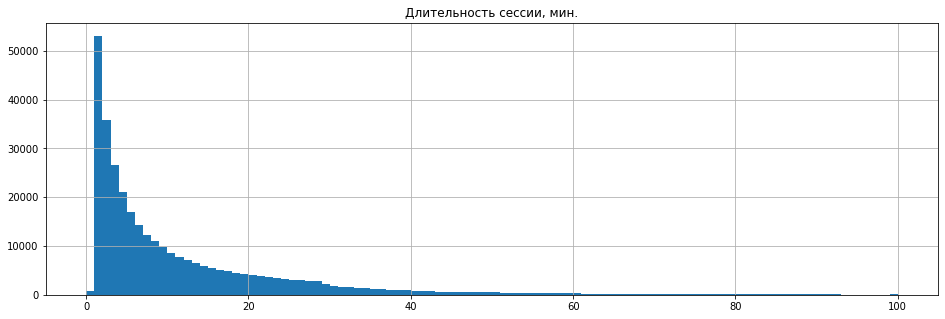

In [45]:
# построим гистограмму для длительности сессий всех визитов
visits['session_duration'].hist(range = (0,100), bins = 100, figsize = (16, 5))
       
plt.title('Длительность сессии, мин.')
plt.show() 

75% сессий длятся не больше 15 минут, встречаются единичные выбросы до 711 мин (11,8 часа). Не будем удалять значения с аномально большой длительностью, чтобы не терять остальную информацию (источник рекламы, устройство, время посещения)

При расчете средней продолжительности будем использовать медиану, чтобы уменьшить влияние отдельных очень больших значений.

### 2.2 Ежедневная активность пользователей 

DAU - количество уникальных пользователей в день, также рассмотрим такие характеристики активности, как количество сессий в день и средняя продолжительность сессии в минутах.

In [46]:
# построим сводную таблицу, сгруппируем датасет с посещениями по дню 
# найдём количество уникальных пользователей, количество посещений, среднюю продолжительность сессии
daily_visits_overall = visits.pivot_table(
                        index = 'day',
                        values = ['uid', 'session_duration'], 
                        aggfunc = {'uid':['nunique', 'count'],
                                   'session_duration':'median'}).reset_index()

# переименуем столбцы: день посещения, средняя продолжительность сессии (ASL), 
# количество сессий, количество уникальных пользователей (DAU)
daily_visits_overall.columns = ['day', 'asl','number_of_sessions','dau']

In [47]:
daily_visits_overall.head()

,day,asl,number_of_sessions,dau
0,2017-06-01,6.0,599,547
1,2017-06-02,6.0,596,549
2,2017-06-03,5.0,429,400
3,2017-06-04,6.0,447,416
4,2017-06-05,6.0,807,738


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


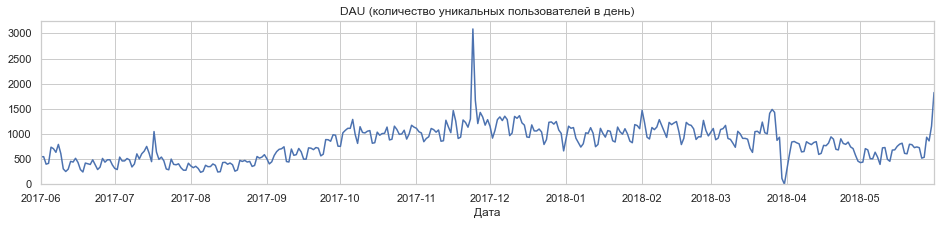

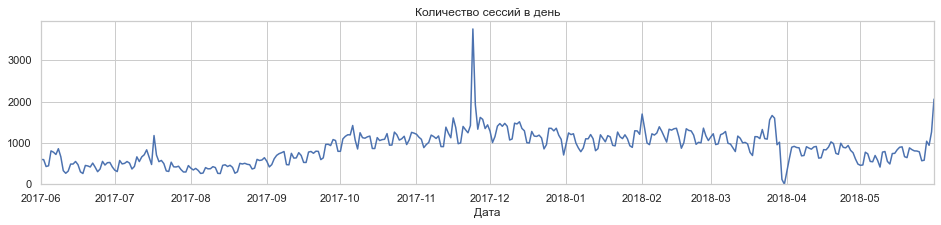

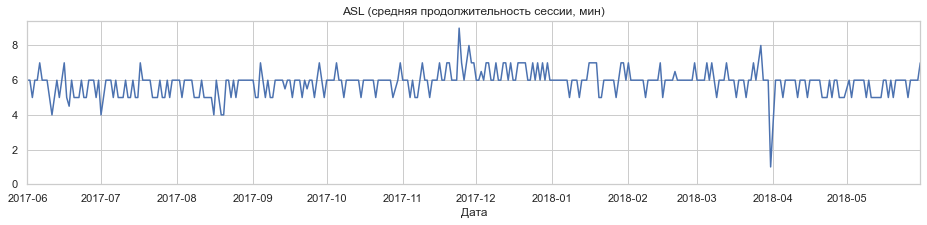

Среднее количество уникальных пользователей в день: 817.5
Среднее количество сессий в день: 888.9
Средняя продолжительность сессии, мин: 5.9


In [48]:
sns.set(style = 'whitegrid')

f, ax = plt.subplots(figsize=(16, 3))
sns.lineplot(x = "day", y = "dau", data = daily_visits_overall)
ax.set(xlabel = 'Дата', ylabel = '', title = 'DAU (количество уникальных пользователей в день)', 
       xlim = ('2017-06-01', '2018-05-31'), ylim = (0, None))

f, ax = plt.subplots(figsize=(16, 3))
sns.lineplot(x = "day", y = "number_of_sessions", data = daily_visits_overall)
ax.set(xlabel = 'Дата', ylabel = '', title = 'Количество сессий в день', 
       xlim = ('2017-06-01', '2018-05-31'), ylim = (0, None))

f, ax = plt.subplots(figsize=(16, 3))
sns.lineplot(x = "day", y = "asl", data = daily_visits_overall)
ax.set(xlabel = 'Дата', ylabel = '', title = 'ASL (средняя продолжительность сессии, мин)', 
       xlim = ('2017-06-01', '2018-05-31'), ylim = (0, None))

plt.show()

print('Среднее количество уникальных пользователей в день: {:.1f}'
      .format(daily_visits_overall['dau'].mean()))
print('Среднее количество сессий в день: {:.1f}' 
      .format(daily_visits_overall['number_of_sessions'].mean()))
print('Средняя продолжительность сессии, мин: {:.1f}' 
      .format(daily_visits_overall['asl'].mean()))

Все три параметра (DAU, количество сессий в день, ASL) изменяются (возрастают и убывают) в течение времени схожим образом. Заметны колебания параметров в течение недели. 

Также, заметен значительный спад параметров в конце марта 2018, это можно связать с технической неполадкой на сайте.
Пиковое значение количества посещений >3000 и длительности сессии (> 9 мин) в конце ноября 2017, возможно, связано с одновременным анонсом большого числа событий на следующий год.

В целом, видно увеличение активности в период с сентября 2017 по май 2018 (количество уникальных пользователей в день стабильно более 500).



---

Рассмотрим средние значения параметров активности в зависимости от дня недели.

In [49]:
# добавим столбец с указанием дня недели (0 - понедельник, 6 - воскресенье)
daily_visits_overall['day_of_week'] = daily_visits_overall['day'].dt.dayofweek

# сгруппируем по дням недели и вычислим средние значения
daily_visits_overall.groupby('day_of_week')['dau', 'number_of_sessions', 'asl'].mean().round(1).reset_index()

,day_of_week,dau,number_of_sessions,asl
0,0,896.7,975.9,6.0
1,1,867.8,947.5,6.1
2,2,841.6,917.8,5.9
3,3,912.2,994.4,6.0
4,4,863.6,946.6,6.0
5,5,666.5,718.5,5.5
6,6,669.3,716.4,5.6


Среднее количество активных пользователей и среднее количество посещений достигают наибольего значения в четверг, и наименьшего - на выходных. 

Среднее время сессии не так сильно зависит от дня недели, но на выходных тоже уменьшается.

---

Рассмотрим параметры посещаемости в зависимости от рекламного источника пользователя.

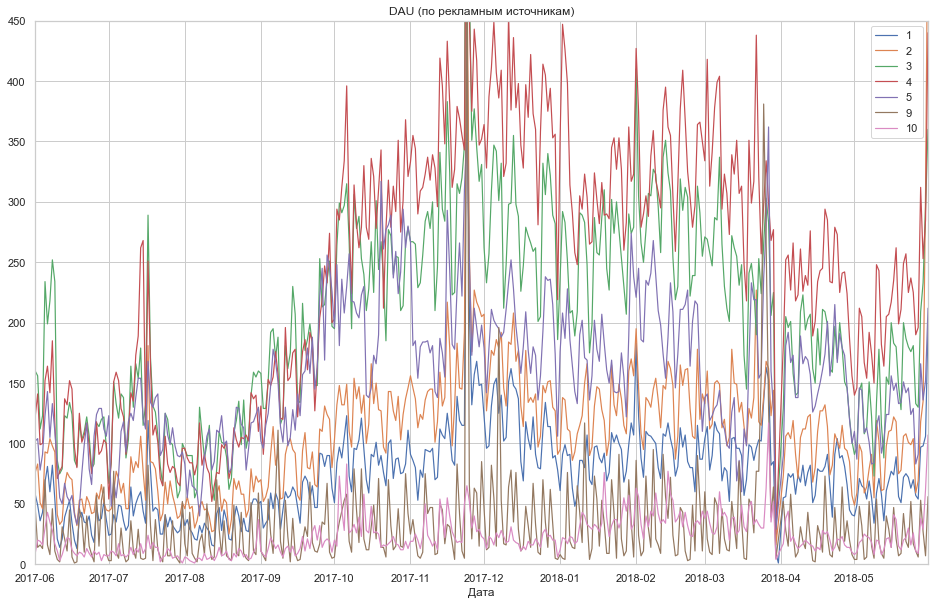

Средние метрики для пользователей с разных источников рекламы:
   source_id   ASL Number_of_sessions    DAU
0          1  10.7               88.3   76.0
1          2   7.8              119.7  110.1
2          3   5.4              211.0  208.3
3          4   5.3              250.4  246.0
4          5   5.1              164.0  156.6
5          9   6.3               33.0   32.6
6         10   6.4               24.7   23.2


In [50]:
f, ax = plt.subplots(figsize=(16, 10))

columns_name = ['source_id', 'ASL', 'Number_of_sessions', 'DAU']
content=[]

# вывод графиков в цикле и расчет средних характеристик для каждого из рекламных источников
for i in visits['source_id'].sort_values().unique():
        visits_source = visits[visits['source_id'] == i]\
                              .pivot_table(index = 'day',
                               values = ['uid', 'session_duration'], 
                               aggfunc = {'uid':['nunique', 'count'],
                                          'session_duration':'median'}).reset_index()

        visits_source.columns = ['day', 'asl','number_of_sessions','dau']
        ax.plot(visits_source['day'], visits_source['dau'], linewidth = 1.2, label = i)
        ax.legend()
        
        content.append([i, '{:.1f}'.format(visits_source['asl'].mean()),
                           '{:.1f}'.format(visits_source['number_of_sessions'].mean()),
                           '{:.1f}'.format(visits_source['dau'].mean())])
        
ax.set(xlabel = 'Дата', ylabel = '', title = 'DAU (по рекламным источникам)', 
       xlim = ('2017-06-01', '2018-05-31'), ylim = (0, 450))        
plt.show()

daily_visits_source = pd.DataFrame(content, columns = columns_name) 
print('Средние метрики для пользователей с разных источников рекламы:')
print(daily_visits_source)

Наибольший вклад в активность дают рекламные источники с ID 2, 3, 4 и 5. Cамые длинные сессии (в среднем) наблюдаем у пользователей с источником рекламы 1.

---

Расмотрим параметры посещаемости в зависимости от устройства пользователя.

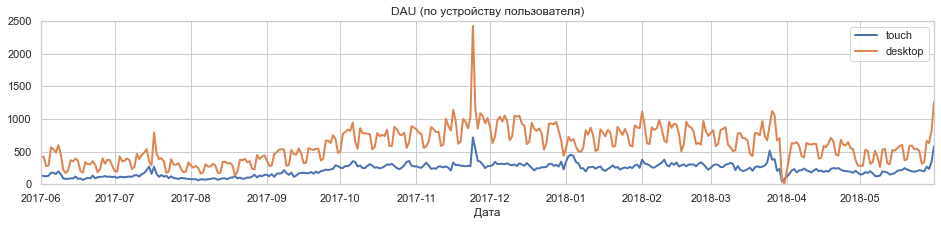

Средние метрики для пользователей с разными устройствами:
  source_id  ASL Number_of_sessions    DAU
0     touch  4.3              233.4  221.4
1   desktop  6.5              656.2  599.7


In [51]:
f, ax = plt.subplots(figsize=(16, 3))

columns_name = ['source_id', 'ASL', 'Number_of_sessions', 'DAU']
content=[]

# вывод графиков в цикле и расчет средних характеристик для каждого из типов устройст
for i in visits['device'].unique():
        visits_device = visits[visits['device'] == i]\
                              .pivot_table(index = 'day',
                               values = ['uid', 'session_duration'], 
                               aggfunc = {'uid':['nunique', 'count'],
                                          'session_duration':'median'}).reset_index()

        visits_device.columns = ['day', 'asl','number_of_sessions','dau']
        ax.plot(visits_device['day'], visits_device['dau'], linewidth = 2, label = i)
        ax.legend()
        
        content.append([i, '{:.1f}'.format(visits_device['asl'].mean()),
                           '{:.1f}'.format(visits_device['number_of_sessions'].mean()),
                           '{:.1f}'.format(visits_device['dau'].mean())])   
        
ax.set(xlabel = 'Дата', ylabel = '', title = 'DAU (по устройству пользователя)', 
       xlim = ('2017-06-01', '2018-05-31'), ylim = (0, 2500))        
plt.show() 

daily_visits_device = pd.DataFrame(content, columns = columns_name) 
print('Средние метрики для пользователей с разными устройствами:')
print(daily_visits_device)

Пользователи активнее посещают сайт с компьютера (примерно в 2,8 раза больше посещений и в 1,5 раза более длинные сессии). При использовании других устройств (смартфоны/планшеты) пользователи меньше привязаны к дню недели (недельные циклы в характеристиках активности выражены слабее).

### 2.3 Еженедельная активность пользователей

WAU - количество уникальных пользователей в неделю, также рассмотрим такие характеристики активности, как количество сессий в неделю и средняя продолжительность сессии в минутах.

In [52]:
# построим сводную таблицу, сгруппируем датасет с посещениями по неделе
# найдём количество уникальных пользователей, количество посещений, среднюю продолжительность сессии
weekly_visits_overall = visits.pivot_table(
                        index = 'week',
                        values = ['uid', 'session_duration'], 
                        aggfunc = {'uid':['nunique', 'count'],
                                   'session_duration':'median'}).reset_index()

# переименуем столбцы: неделя посещения, средняя продолжительность сессии (ASL), 
# количество сессий, количество уникальных пользователей (WAU)
weekly_visits_overall.columns = ['week', 'asl','number_of_sessions','wau']

In [53]:
weekly_visits_overall.head()

,week,asl,number_of_sessions,wau
0,2017-05-29,6,2071,1816
1,2017-06-05,6,4422,3699
2,2017-06-12,5,2880,2514
3,2017-06-19,5,2914,2564
4,2017-06-26,5,3133,2727


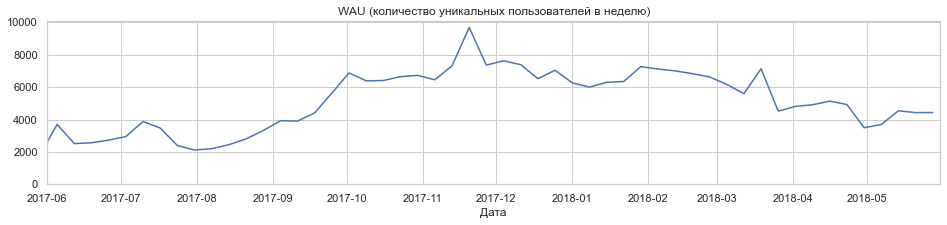

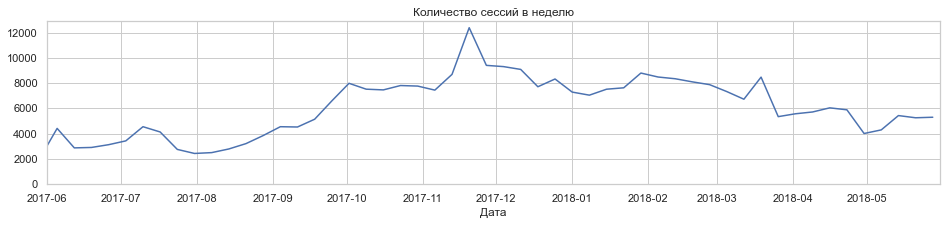

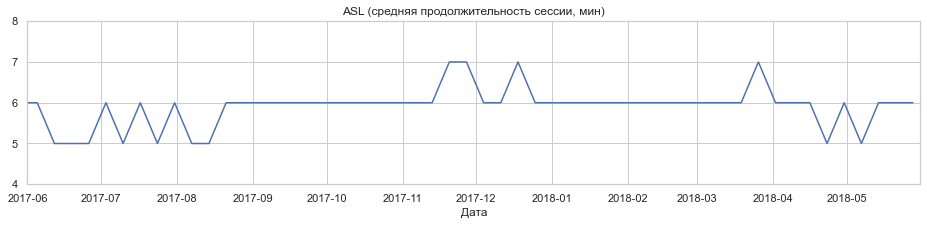

Среднее количество уникальных пользователей в неделю: 5147.6
Среднее количество сессий в неделю: 6105.0
Средняя продолжительность сессии, мин: 5.9


In [54]:
f, ax = plt.subplots(figsize=(16, 3))
sns.lineplot(x = "week", y = "wau", data = weekly_visits_overall)
ax.set(xlabel = 'Дата', ylabel = '', title = 'WAU (количество уникальных пользователей в неделю)', 
       xlim = ('2017-06-01', '2018-05-31'), ylim = (0, None))

f, ax = plt.subplots(figsize=(16, 3))
sns.lineplot(x = "week", y = "number_of_sessions", data = weekly_visits_overall)
ax.set(xlabel = 'Дата', ylabel = '', title = 'Количество сессий в неделю', 
       xlim = ('2017-06-01', '2018-05-31'), ylim = (0, None))

f, ax = plt.subplots(figsize=(16, 3))
sns.lineplot(x = "week", y = "asl", data = weekly_visits_overall)
ax.set(xlabel = 'Дата', ylabel = '', title = 'ASL (средняя продолжительность сессии, мин)', 
       xlim = ('2017-06-01', '2018-05-31'), ylim = (4, 8))

plt.show()

print('Среднее количество уникальных пользователей в неделю: {:.1f}' 
      .format(weekly_visits_overall['wau'].mean()))
print('Среднее количество сессий в неделю: {:.1f}' 
      .format(weekly_visits_overall['number_of_sessions'].mean()))
print('Средняя продолжительность сессии, мин: {:.1f}' 
      .format(weekly_visits_overall['asl'].mean()))

На графиках недельной активности более заметно увеличение количества посещений и длительности сессии в период с сентября 2017 по май 2018. Осенью и зимой люди больше интересуются событиями, продвигаемыми на Яндекс.Афише.

Локальные увеличения посещаемости, возможно связаны с одновременными анонсами будущих мероприятий, или ежемесячной рассылкой.

---

Рассмотрим параметры посещаемости в зависимости от рекламного источника пользователя.

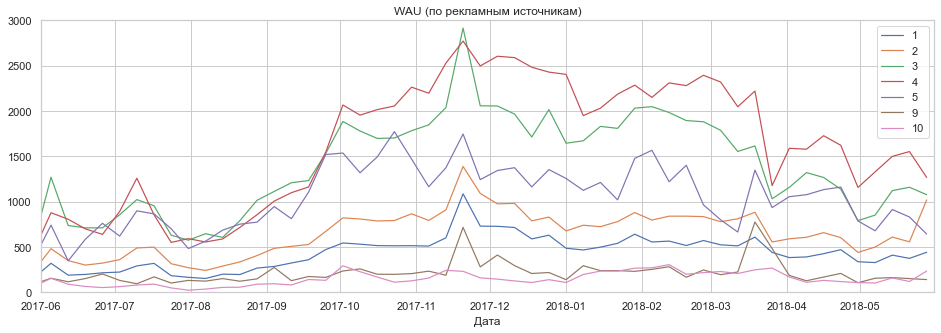

Средние метрики для пользователей с разных источников рекламы:
   source_id   ASL Number_of_sessions     WAU
0          1  10.7              606.5   437.8
1          2   7.7              820.2   653.5
2          3   5.3             1445.0  1401.7
3          4   5.3             1715.0  1636.1
4          5   5.1             1123.0  1040.8
5          9   5.1              226.0   215.8
6         10   6.0              169.3   148.4


In [55]:
f, ax = plt.subplots(figsize=(16, 5))

columns_name = ['source_id', 'ASL', 'Number_of_sessions', 'WAU']
content=[]

# вывод графиков в цикле и расчет средних характеристик для каждого из рекламных источников
for i in visits['source_id'].sort_values().unique():
        visits_source = visits[visits['source_id'] == i]\
                                   .pivot_table(index = 'week',
                                    values = ['uid', 'session_duration'], 
                                    aggfunc = {'uid':['nunique', 'count'],
                                               'session_duration':'median'}).reset_index()

        visits_source.columns = ['week', 'asl','number_of_sessions','wau']
        ax.plot(visits_source['week'], visits_source['wau'], linewidth = 1.2, label = i)
        ax.legend()
        
        content.append([i, '{:.1f}'.format(visits_source['asl'].mean()),
                           '{:.1f}'.format(visits_source['number_of_sessions'].mean()),
                           '{:.1f}'.format(visits_source['wau'].mean())])
        
ax.set(xlabel = 'Дата', ylabel = '', title = 'WAU (по рекламным источникам)', 
       xlim = ('2017-06-01', '2018-05-31'), ylim = (0, 3000))        
plt.show()

weekly_visits_source = pd.DataFrame(content, columns = columns_name) 
print('Средние метрики для пользователей с разных источников рекламы:')
print(weekly_visits_source)        

Наибольший вклад в недельную посещаемость дают рекламные источники с ID 3, 4 и 5. Cамые длинные сессии (в среднем) наблюдаем у пользователей с источником рекламы 1.

---

Рассмотрим параметры посещаемости в зависимости от устройства пользователя.

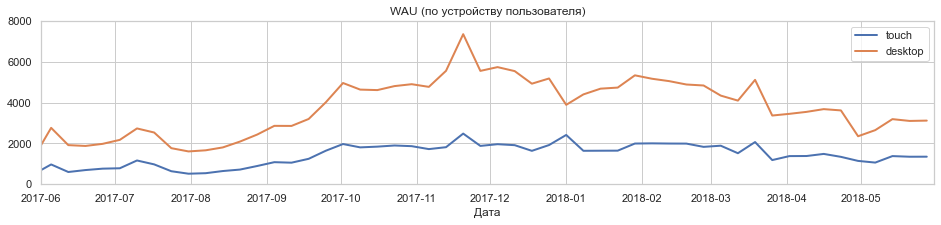

Средние метрики для пользователей с разными устройствами:
  source_id  ASL Number_of_sessions     WAU
0     touch  4.2             1598.5  1433.8
1   desktop  6.6             4506.5  3756.2


In [56]:
f, ax = plt.subplots(figsize=(16, 3))

columns_name = ['source_id', 'ASL', 'Number_of_sessions', 'WAU']
content=[]

# вывод графиков в цикле и расчет средних характеристик для каждого из типов устройст
for i in visits['device'].unique():
        visits_device = visits[visits['device'] == i]\
                                   .pivot_table(index = 'week',
                                    values = ['uid', 'session_duration'], 
                                    aggfunc = {'uid':['nunique', 'count'],
                                               'session_duration':'median'}).reset_index()

        visits_device.columns = ['week', 'asl','number_of_sessions','wau']
        ax.plot(visits_device['week'], visits_device['wau'], linewidth = 2, label = i)
        ax.legend()
        
        content.append([i, '{:.1f}'.format(visits_device['asl'].mean()),
                           '{:.1f}'.format(visits_device['number_of_sessions'].mean()),
                           '{:.1f}'.format(visits_device['wau'].mean())])   
        
ax.set(xlabel = 'Дата', ylabel = '', title = 'WAU (по устройству пользователя)', 
       xlim = ('2017-06-01', '2018-05-31'), ylim = (0, 8000))        
plt.show() 

weekly_visits_device = pd.DataFrame(content, columns = columns_name) 
print('Средние метрики для пользователей с разными устройствами:')
print(weekly_visits_device)

Графики для пользователей с разными устройствами подобны, за исключением начала 2018 года - в новогодние праздники пользователи меньше заходят на сайт с компьютера, и больше - с мобильных устройств.

### 2.4 Ежемесячная активность пользователей

Рассмотрим показатели активности пользователей, распределенные по месяцам.

In [57]:
# построим сводную таблицу, сгруппируем датасет с посещениями по месяцу
# найдём количество уникальных пользователей, количество посещений, среднюю продолжительность сессии
monthly_visits_overall = visits.pivot_table(
                        index = 'month',
                        values = ['uid', 'session_duration'], 
                        aggfunc = {'uid':['nunique', 'count'],
                                   'session_duration':'median'}).reset_index()

# переименуем столбцы: месяц посещения, средняя продолжительность сессии (ASL), 
# количество сессий, количество уникальных пользователей (MAU)
monthly_visits_overall.columns = ['month', 'asl','number_of_sessions','mau']

In [58]:
monthly_visits_overall.head()

,month,asl,number_of_sessions,mau
0,2017-06-01,6,14772,11883
1,2017-07-01,6,15990,12722
2,2017-08-01,5,12910,10463
3,2017-09-01,6,21489,17114
4,2017-10-01,6,34092,26790


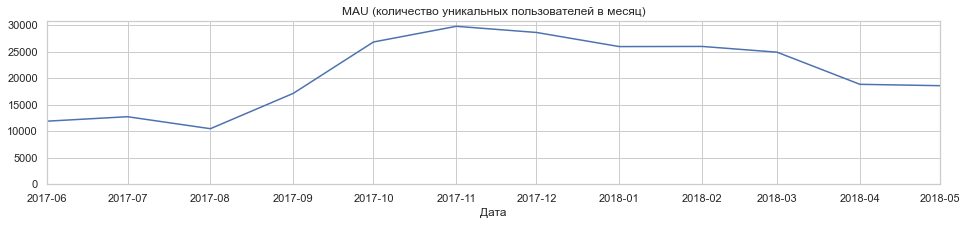

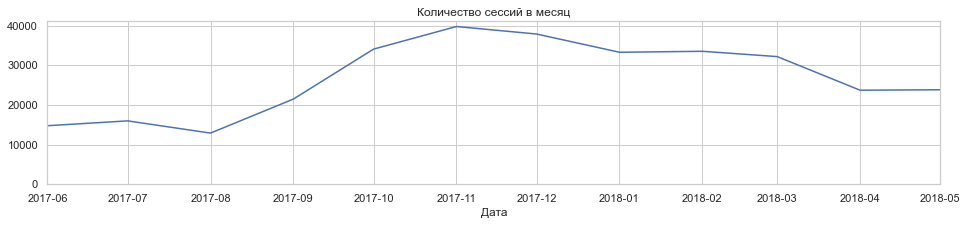

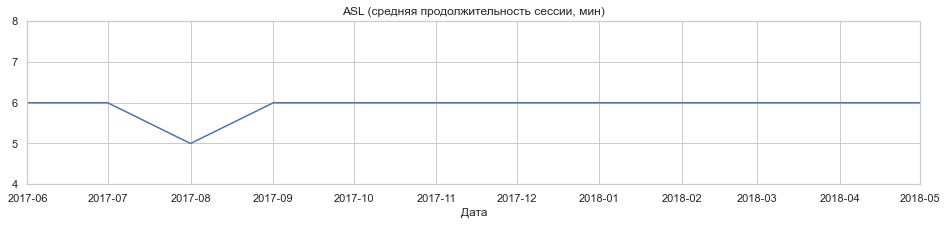

Среднее количество уникальных пользователей в месяц: 20952.9
Среднее количество сессий в месяц: 26963.7
Средняя продолжительность сессии, мин: 5.9


In [59]:
f, ax = plt.subplots(figsize=(16, 3))
sns.lineplot(x = "month", y = "mau", data = monthly_visits_overall)
ax.set(xlabel = 'Дата', ylabel = '', title = 'MAU (количество уникальных пользователей в месяц)', 
       xlim = ('2017-06', '2018-05'), ylim = (0, None))

f, ax = plt.subplots(figsize=(16, 3))
sns.lineplot(x = "month", y = "number_of_sessions", data = monthly_visits_overall)
ax.set(xlabel = 'Дата', ylabel = '', title = 'Количество сессий в месяц', 
       xlim = ('2017-06', '2018-05'), ylim = (0, None))

f, ax = plt.subplots(figsize=(16, 3))
sns.lineplot(x = "month", y = "asl", data = monthly_visits_overall)
ax.set(xlabel = 'Дата', ylabel = '', title = 'ASL (средняя продолжительность сессии, мин)', 
       xlim = ('2017-06', '2018-05'), ylim = (4, 8))

plt.show()

print('Среднее количество уникальных пользователей в месяц: {:.1f}' 
       .format(monthly_visits_overall['mau'].mean()))
print('Среднее количество сессий в месяц: {:.1f}' 
       .format(monthly_visits_overall['number_of_sessions'].mean()))
print('Средняя продолжительность сессии, мин: {:.1f}' 
       .format(monthly_visits_overall['asl'].mean()))

На графиках активности по месяцам заметно увеличение количества посещений в период с сентября 2017 по май 2018. Осенью и зимой люди больше интересуются событиями, продвигаемыми на Яндекс.Афише.

---

Рассмотрим параметры посещаемости в зависимости от рекламного источника пользователя.

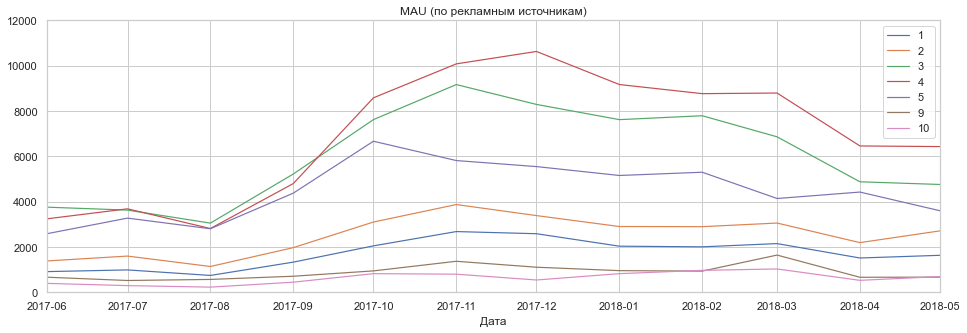

Средние метрики для пользователей с разных источников рекламы:
   source_id   ASL Number_of_sessions     MAU
0          1  10.7             2678.8  1718.4
1          2   7.8             3622.3  2517.3
2          3   5.3             6382.0  6055.0
3          4   5.2             7574.7  6955.9
4          5   5.0             4960.0  4474.3
5          9   5.2              998.2   894.8
6         10   6.0              747.6   630.1


In [60]:
f, ax = plt.subplots(figsize=(16, 5))

columns_name = ['source_id', 'ASL', 'Number_of_sessions', 'MAU']
content=[]

# вывод графиков в цикле и расчет средних характеристик для каждого из рекламных источников
for i in visits['source_id'].sort_values().unique():
        visits_source = visits[visits['source_id'] == i]\
                                   .pivot_table(index = 'month',
                                    values = ['uid', 'session_duration'], 
                                    aggfunc = {'uid':['nunique', 'count'],
                                               'session_duration':'median'}).reset_index()

        visits_source.columns = ['month', 'asl','number_of_sessions','mau']
        ax.plot(visits_source['month'], visits_source['mau'], linewidth = 1.2, label = i)
        ax.legend()
        
        content.append([i, '{:.1f}'.format(visits_source['asl'].mean()),
                           '{:.1f}'.format(visits_source['number_of_sessions'].mean()),
                           '{:.1f}'.format(visits_source['mau'].mean())])
        
ax.set(xlabel = 'Дата', ylabel = '', title = 'MAU (по рекламным источникам)', 
       xlim = ('2017-06', '2018-05'), ylim = (0, 12000))        
plt.show()

monthly_visits_source = pd.DataFrame(content, columns = columns_name) 
print('Средние метрики для пользователей с разных источников рекламы:')
print(monthly_visits_source)

Наибольший вклад в ежемесячную посещаемость дают рекламные источники с ID 3 и 4. Для каждого из наиболее влиятельных источников рекламы видим максимум активности в разные месяцы: 
- октябрь для source_id = 5;
- ноябрь для source_id = 3;
- декабрь для source_id = 4.

---

Рассмотрим параметры посещаемости в зависимости от устройства пользователя.

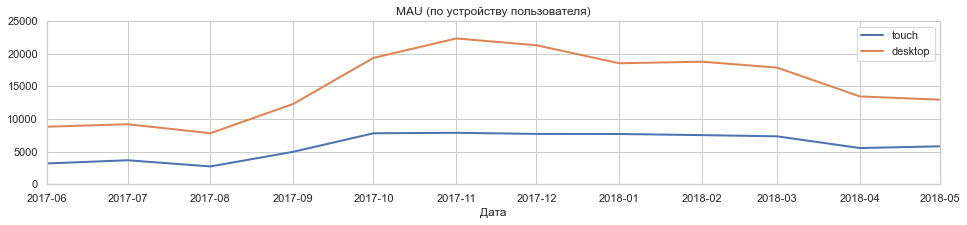

Средние метрики для пользователей с разными устройствами:
  source_id  ASL Number_of_sessions      MAU
0     touch  4.2             7060.0   5998.5
1   desktop  6.7            19903.7  15237.7


In [61]:
f, ax = plt.subplots(figsize=(16, 3))

columns_name = ['source_id', 'ASL', 'Number_of_sessions', 'MAU']
content=[]

# вывод графиков в цикле и расчет средних характеристик для каждого из типов устройст
for i in visits['device'].unique():
        visits_device = visits[visits['device'] == i]\
                        .pivot_table(index = 'month',
                         values = ['uid', 'session_duration'], 
                         aggfunc = {'uid':['nunique', 'count'],
                                    'session_duration':'median'}).reset_index()

        visits_device.columns = ['month', 'asl','number_of_sessions','mau']
        ax.plot(visits_device['month'], visits_device['mau'], linewidth = 2, label = i)
        ax.legend()
        
        content.append([i, '{:.1f}'.format(visits_device['asl'].mean()),
                           '{:.1f}'.format(visits_device['number_of_sessions'].mean()),
                           '{:.1f}'.format(visits_device['mau'].mean())])   
        
ax.set(xlabel = 'Дата', ylabel = '', title = 'MAU (по устройству пользователя)', 
       xlim = ('2017-06', '2018-05'), ylim = (0, 25000))        
plt.show() 

monthly_visits_device = pd.DataFrame(content, columns = columns_name) 
print('Средние метрики для пользователей с разными устройствами:')
print(monthly_visits_device)

В течение зимы (с октября 2017 по март 2018) активность пользователей с компьютера увеличивается, а активность пользователей с мобильных устройств остается неизменной. Возможно, что в это время года пользователи проводят больше времени дома (имеют доступ к компьютеру), и версия сайта для компьютера удобнее в использовании.

### 2.5 Когортный анализ повторных посещений

Рассмотрим повторную активность пользователей: какой процент пользователей возвращается к сайту Яндекс.Афиши, и в течение какого периода после первого использования это происходит.

Для начала разделим всех пользователей на группы (когорты) по признаку: месяц первой сессии.

In [62]:
# найдём месяц первого визита для каждого пользователя и запишем его в отдельный датасет
first_visit = visits.groupby(['uid'])['month'].min()
first_visit.name = 'first_visit_month'

# для каждого пользователя добавим столбец с указанием месяца первого визита
visits = visits.join(first_visit, on = 'uid')
visits.head(3)

,start_ts,end_ts,device,source_id,uid,day,week,month,session_duration,first_visit_month
0,2017-12-20 17:20:00,2017-12-20 17:38:00,touch,4,16879256277535980062,2017-12-20,2017-12-18,2017-12-01,18,2017-12-01
1,2018-02-19 16:53:00,2018-02-19 17:21:00,desktop,2,104060357244891740,2018-02-19,2018-02-19,2018-02-01,28,2018-02-01
3,2018-05-20 10:59:00,2018-05-20 11:23:00,desktop,9,16174680259334210214,2018-05-20,2018-05-14,2018-05-01,24,2018-03-01


In [63]:
# для каждой сессии запишем разницу (в месяцах) между месяцем сессии и месяцем первого посещения
visits['cohort_lifetime'] = visits['month'] - visits['first_visit_month']

visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].astype(int)
visits.head(3)

,start_ts,end_ts,device,source_id,uid,day,week,month,session_duration,first_visit_month,cohort_lifetime
0,2017-12-20 17:20:00,2017-12-20 17:38:00,touch,4,16879256277535980062,2017-12-20,2017-12-18,2017-12-01,18,2017-12-01,0
1,2018-02-19 16:53:00,2018-02-19 17:21:00,desktop,2,104060357244891740,2018-02-19,2018-02-19,2018-02-01,28,2018-02-01,0
3,2018-05-20 10:59:00,2018-05-20 11:23:00,desktop,9,16174680259334210214,2018-05-20,2018-05-14,2018-05-01,24,2018-03-01,2


In [64]:
# вычислим количество уникальных пользователей с группировкой по месяцу сессии и месяцу первого посещения
visit_monthly_cohorts = visits.groupby(['first_visit_month','cohort_lifetime'])\
                              .agg({'uid':'nunique'}).reset_index()

# найдём размеры когорт (количество уникальных пользователей на 0-й месяц жизни когорты)
inital_users_count = visit_monthly_cohorts[visit_monthly_cohorts['cohort_lifetime'] == 0][['first_visit_month','uid']]

# добавим инфомацию о размерах когорт к сгруппированной таблице
inital_users_count = inital_users_count.rename(columns = {'uid':'cohort_users'})
visit_monthly_cohorts = visit_monthly_cohorts.merge(inital_users_count, on = 'first_visit_month')
visit_monthly_cohorts.head(3)

,first_visit_month,cohort_lifetime,uid,cohort_users
0,2017-06-01,0,11883,11883
1,2017-06-01,2,605,11883
2,2017-06-01,3,710,11883


In [65]:
# вычислим коэффициент удержания (retention rate) как отношение количества уникальных пользователей
# в каждый месяц жизни когорты к первоначальному размеру когорты
visit_monthly_cohorts['retention'] = visit_monthly_cohorts['uid']/ visit_monthly_cohorts['cohort_users']

visit_monthly_cohorts['first_visit_month'] = visit_monthly_cohorts['first_visit_month'].dt.strftime('%Y-%m')

# выведем сводную таблицу, где для каждой когорты и каждого её месяца жизни посчитан коэффициент удержания
retention_pivot = visit_monthly_cohorts.pivot_table(index = 'first_visit_month',
                                                    columns = 'cohort_lifetime',
                                                    values = 'retention',
                                                    aggfunc = 'sum').round(2)
retention_pivot.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10
first_visit_month,,,,,,,,,,,
2017-06,1.0,,0.05,0.06,0.07,0.07,0.06,0.06,0.08,0.04,0.04
2017-07,1.0,0.05,0.05,0.06,0.06,0.05,0.04,0.07,,0.05,
2017-08,1.0,0.07,0.06,0.06,0.05,0.04,0.06,0.03,0.02,,
2017-09,1.0,,0.1,,0.04,0.06,0.02,0.02,,,
2017-10,1.0,0.08,0.05,0.04,0.06,0.02,0.02,,,,
2017-11,1.0,,0.04,0.06,0.02,0.02,,,,,
2017-12,1.0,0.05,0.06,0.02,0.02,,,,,,
2018-01,1.0,0.09,0.02,0.02,,,,,,,
2018-02,1.0,0.02,0.02,,,,,,,,


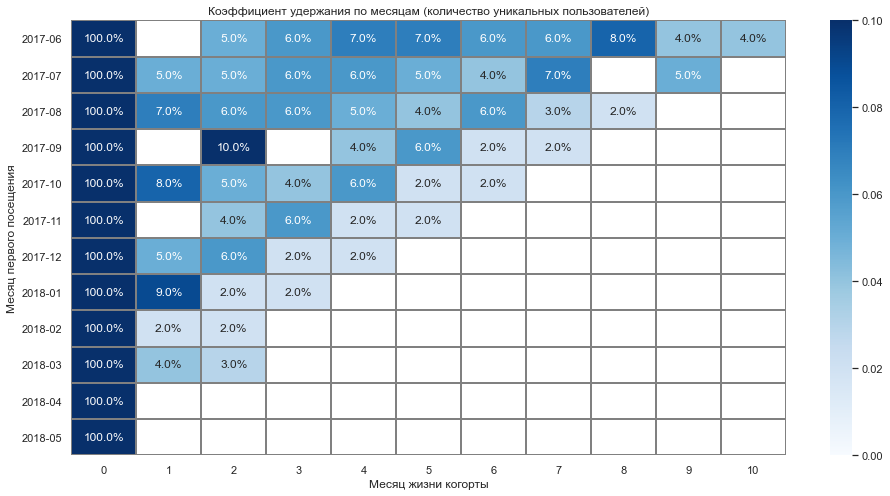

In [66]:
# отобразим сводную таблицу в виде тепловой карты
f, ax = plt.subplots(figsize=(16, 8))

sns.heatmap(retention_pivot, annot = True, fmt = '.1%', 
            linewidths = 1, linecolor = 'gray', cmap = "Blues",
            vmin = 0, vmax = 0.1)
ax.set(xlabel = 'Месяц жизни когорты', ylabel = 'Месяц первого посещения',
title = 'Коэффициент удержания по месяцам (количество уникальных пользователей)') 

plt.show()

Видно, что процент пользователей, повторно посещающих сайт, в каждый месяц не превышает 10%, и в среднем составляет  от 2% до 6%.

## 3. Посещения и заказы на сайте
Рассмотрим наборы данных с заказами и посещениями и выясним, когда пользователи начинуют покупать, как часто они это делают и сколько денег приносят.

### 3.1 Время совершения первого заказа 

In [67]:
# выделим день покупки в отдельный столбец
orders['order_day'] = orders['buy_ts'].astype('datetime64[D]')

# выделим день первой покупки
first_order_day = orders.groupby(['uid'])['order_day'].min()
first_order_day.name = 'first_order_day'

# и добавим его в виде отдельного столбца
orders = orders.join(first_order_day, on = 'uid')

In [68]:
# найдём день первого посещения для каждого пользователя и запишем его в отдельный датасет
first_visit_day = visits.groupby(['uid'])['day'].min()
first_visit_day.name = 'first_visit_day'

# добавим к таблице с заказами информацию о дне первого посещения 
orders = orders.join(first_visit_day, on = 'uid')
orders.head(3)

,buy_ts,revenue,uid,order_day,first_order_day,first_visit_day
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01


In [69]:
# пользователи, которые совершили заказ, но не были записаны в visits
print(len(orders[~orders['uid'].isin(visits['uid'])]))
orders[~orders['uid'].isin(visits['uid'])].head(3)

475


,buy_ts,revenue,uid,order_day,first_order_day,first_visit_day
378,2017-06-05 11:56:00,3.67,1243031607085908316,2017-06-05,2017-06-05,NaT
577,2017-06-06 14:01:00,0.37,3211627736227655903,2017-06-06,2017-06-06,NaT
752,2017-06-07 12:06:00,6.97,8611155764823884246,2017-06-07,2017-06-07,NaT


Для части пользователей отсутствуют записи о посещениях. В таком случае, датой первого посещения будет дата первого заказа.

In [70]:
orders.loc[~orders.loc[:,'uid'].isin(visits['uid']), 'first_visit_day'] = \
orders.loc[~orders.loc[:,'uid'].isin(visits['uid'])]['first_order_day']

In [71]:
# проверим, есть ли пропуски
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50364 entries, 0 to 50414
Data columns (total 6 columns):
buy_ts             50364 non-null datetime64[ns]
revenue            50364 non-null float64
uid                50364 non-null uint64
order_day          50364 non-null datetime64[ns]
first_order_day    50364 non-null datetime64[ns]
first_visit_day    50364 non-null datetime64[ns]
dtypes: datetime64[ns](4), float64(1), uint64(1)
memory usage: 2.7 MB


Отсутствуют пропущенные значения.

In [72]:
# зададим функцию, которая возвращает минимальное значение из двух: 
# месяц первого заказа и месяц первого посещения
def min_date(row):
    first_order_day = row['first_order_day']
    first_visit_day = row['first_visit_day']
    return min(first_order_day, first_visit_day)        

In [73]:
# после объединения таблиц заказов и посещений для некоторых uid 
# месяц первого посещения из таблицы visits оказался позже месяца первого заказа - 
# запишем в качестве месяца первого заказа более ранний
orders['first_visit_day'] = orders.apply(min_date, axis = 1)

In [74]:
# найдём, какой период времени проходит между первым посещением сайта и первым заказом
orders['first_visit_first_order_timedelta'] = orders['first_order_day'] - orders['first_visit_day']
orders['first_visit_first_order_timedelta'] = orders['first_visit_first_order_timedelta'] / np.timedelta64(1, 'D')
orders['first_visit_first_order_timedelta'] = orders['first_visit_first_order_timedelta'].astype(int)
orders.head(3)

,buy_ts,revenue,uid,order_day,first_order_day,first_visit_day,first_visit_first_order_timedelta
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,0


In [75]:
# выделим в отдельный датасет столбцы uid, first_visit_day, first_order_day
# и visit_order_timedelta
first_visit_first_order = orders[['uid', 'first_order_day', 'first_visit_day', 'first_visit_first_order_timedelta']]

In [76]:
# удалим дубликаты, в датасете останется только 1 запись для каждого uid
first_visit_first_order = first_visit_first_order.drop_duplicates()
first_visit_first_order.head(3)

,uid,first_order_day,first_visit_day,first_visit_first_order_timedelta
0,10329302124590727494,2017-06-01,2017-06-01,0
1,11627257723692907447,2017-06-01,2017-06-01,0
2,17903680561304213844,2017-06-01,2017-06-01,0


count    36509.00
mean        15.48
std         45.11
min          0.00
25%          0.00
50%          0.00
75%          1.00
max        363.00
Name: first_visit_first_order_timedelta, dtype: float64


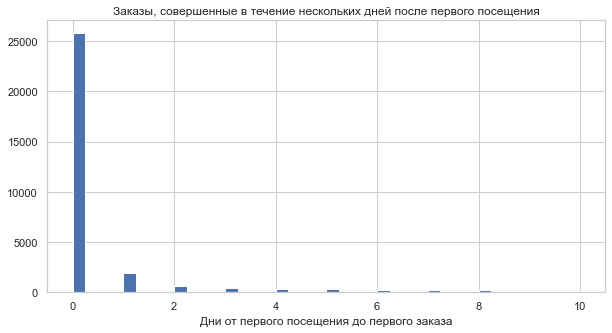

In [77]:
# характеристики распределения столбца с количеством дней между первым посещением и первым заказом
print(first_visit_first_order['first_visit_first_order_timedelta'].describe().round(2))

ax = first_visit_first_order['first_visit_first_order_timedelta'].hist(range =(0, 10), 
     bins = 40, figsize = (10, 5))

ax.set(xlabel = 'Дни от первого посещения до первого заказа', ylabel = '',
       title = 'Заказы, совершенные в течение нескольких дней после первого посещения') 

plt.show()

In [78]:
# суммарное количество пользователей, совершивших заказ не в день первого посещения
print(first_visit_first_order.query('first_visit_first_order_timedelta > 0')['uid'].count())

# количество дней от первого посещения до первого заказа и 
# количество пользователей, совершивших заказ 
first_visit_first_order['first_visit_first_order_timedelta'].value_counts().head(10)

10738


0    25771
1     1893
2      644
3      429
4      367
5      288
6      255
7      229
8      204
9      152
Name: first_visit_first_order_timedelta, dtype: int64

Примерно 70% заказов совершаются в день первого посещения сайта, остальные пользователи совершают заказы позже.

---

### 3.2 Динамика заказов

Рассмотрим заказы, совершенные в течение каждого месяца.

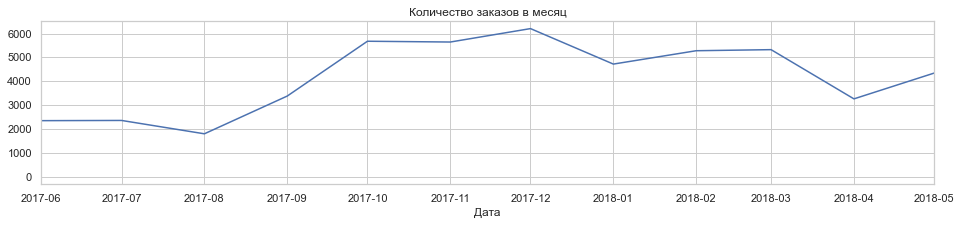

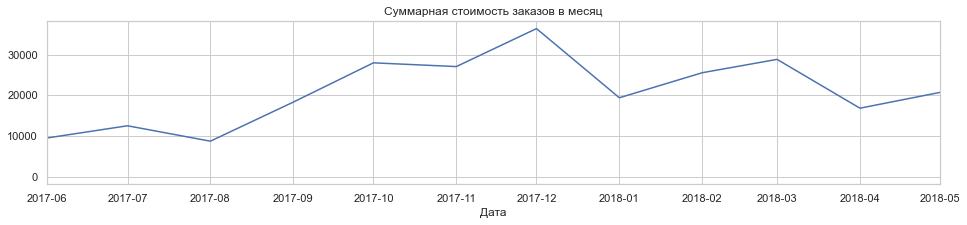

Среднее количество заказов в месяц: 3874.2
Средняя суммарная стоимость заказов в месяц: 19389.0


In [79]:
orders = orders[['buy_ts', 'revenue', 'uid']]

# выделим месяц заказа в отдельный столбец
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders.head()

# сгруппируем таблицу по месяцу, найдём количество и суммарную стоимости заказов
orders_count = orders.groupby('order_month')\
                     .agg({'uid':'count', 
                           'revenue': 'sum'}).reset_index()
orders_count.columns = ['order_month', 'number_of_orders','sum_revenue']

f, ax = plt.subplots(figsize=(16, 3))
sns.lineplot(x = "order_month", y = "number_of_orders", data = orders_count)
ax.set(xlabel = 'Дата', ylabel = '', title = 'Количество заказов в месяц', 
       xlim = ('2017-06', '2018-05'))

f, ax = plt.subplots(figsize=(16, 3))
sns.lineplot(x = "order_month", y = "sum_revenue", data = orders_count)
ax.set(xlabel = 'Дата', ylabel = '', title = 'Суммарная стоимость заказов в месяц', 
       xlim = ('2017-06', '2018-05'))

plt.show()

print('Среднее количество заказов в месяц: {:.1f}'\
      .format(orders_count['number_of_orders'].mean()))
print('Средняя суммарная стоимость заказов в месяц: {:.1f}'\
      .format(orders_count['sum_revenue'].mean()))

Количество заказов увеличивается в период с августа 2017 до апреля 2018, что совпадает с сезонным увеличением активности 
пользователей (что было представлено на графиках активности по месяцам и неделям).

In [80]:
print('Среднее количество заказов для каждого пользователя: {:.1f}'
      .format(orders.groupby('uid')['revenue'].count().reset_index()['revenue'].mean()))

Среднее количество заказов для каждого пользователя: 1.4


---

### 3.3 Средний чек

Для расчета среднего чека в зависимости от устройства пользователя и источника рекламы, соединим таблицы с заказами и посещениями по условию равенства `uid`, и нахождению времени заказа между началом и окончанием сессии.

In [81]:
orders.head(3)

,buy_ts,revenue,uid,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01


In [82]:
visits = visits[['start_ts', 'end_ts', 'device', 'source_id', 'uid']]
visits.head(3)

,start_ts,end_ts,device,source_id,uid
0,2017-12-20 17:20:00,2017-12-20 17:38:00,touch,4,16879256277535980062
1,2018-02-19 16:53:00,2018-02-19 17:21:00,desktop,2,104060357244891740
3,2018-05-20 10:59:00,2018-05-20 11:23:00,desktop,9,16174680259334210214


In [83]:
# соединим датасеты по условию равенства uid так, чтобы в результирующем
# наборе данных были все строки из таблицы с заказами
orders_visits = pd.merge(orders, visits, on = 'uid', how = 'left')

In [84]:
orders_visits.head()

,buy_ts,revenue,uid,order_month,start_ts,end_ts,device,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:09:00,2017-06-01 00:11:00,desktop,1.0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:14:00,2017-06-01 00:25:00,desktop,2.0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:25:00,2017-06-01 00:34:00,desktop,2.0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:14:00,2017-06-01 00:33:00,desktop,2.0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:31:00,2017-06-01 07:59:00,desktop,3.0


In [85]:
# информация о получившемся датасете
orders_visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720391 entries, 0 to 720390
Data columns (total 8 columns):
buy_ts         720391 non-null datetime64[ns]
revenue        720391 non-null float64
uid            720391 non-null uint64
order_month    720391 non-null datetime64[ns]
start_ts       719916 non-null datetime64[ns]
end_ts         719916 non-null datetime64[ns]
device         719916 non-null object
source_id      719916 non-null float64
dtypes: datetime64[ns](4), float64(2), object(1), uint64(1)
memory usage: 49.5+ MB


Получили датасет с большим количеством записей: 
для каждого заказа каждого пользователя были добавлены данные о каждой из его сессий, т.е. данные частично дублируются.

In [86]:
orders_visits[['buy_ts', 'uid', 'revenue']].duplicated().sum()

670027

In [87]:
# оставим только те записи, у которых время совершения заказа находится между
# временем начала и окончания зарегистрированной сессии
orders_visits = orders_visits.query('start_ts <= buy_ts <= end_ts')

In [88]:
orders_visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35409 entries, 0 to 720390
Data columns (total 8 columns):
buy_ts         35409 non-null datetime64[ns]
revenue        35409 non-null float64
uid            35409 non-null uint64
order_month    35409 non-null datetime64[ns]
start_ts       35409 non-null datetime64[ns]
end_ts         35409 non-null datetime64[ns]
device         35409 non-null object
source_id      35409 non-null float64
dtypes: datetime64[ns](4), float64(2), object(1), uint64(1)
memory usage: 2.4+ MB


Часть данных утеряна - общее количество заказов меньше, чем было в начальном датасете. Это произошло из-за того, что некоторые пользователи, совершившие заказ, совсем не были записаны в таблицу посещений. И для некоторых из тех, кто был записан, время совершения заказа выходит за рамки сессии. 

Для анализа среднего чека и зависимости его размера от различных параметров будем использовать только эту часть данных, т.к. она достоверно и полно представляет каждого пользователя, его сессию и заказ, а также его устройство и источник рекламы.

Будем считать, что тот источник рекламы, который указан в записи о посещении с заказом, и привёл пользователя к покупке.

In [89]:
orders_visits[['buy_ts', 'uid', 'revenue']].duplicated().sum()

0

Не осталось повторяющихся записей.

In [90]:
# приведем id рекламного источника к целочисленному типу
orders_visits['source_id'] = orders_visits['source_id'].astype('int')

In [91]:
orders_visits.head(3)

,buy_ts,revenue,uid,order_month,start_ts,end_ts,device,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:09:00,2017-06-01 00:11:00,desktop,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:14:00,2017-06-01 00:25:00,desktop,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:25:00,2017-06-01 00:34:00,desktop,2


In [92]:
# суммарная выручка от пользователей, пришедших из разных рекламных источников
orders_visits.groupby('source_id')['revenue'].sum()

source_id
1     28185.42
2     33100.05
3     30047.33
4     34375.06
5     33274.02
9      2756.29
10     3074.98
Name: revenue, dtype: float64

Больше всего выручки принесли пользователи с источников 1-5.

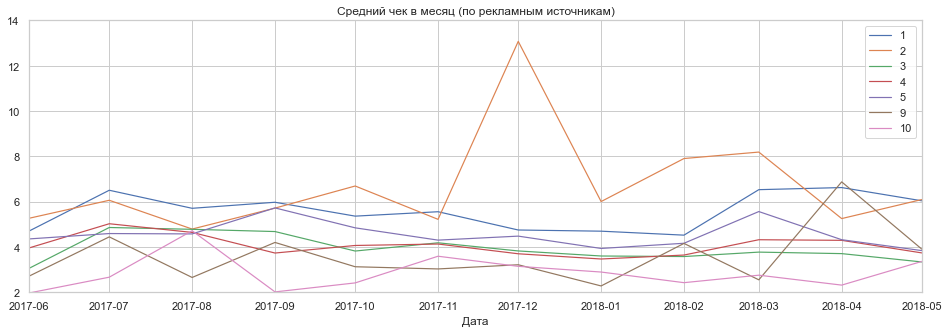

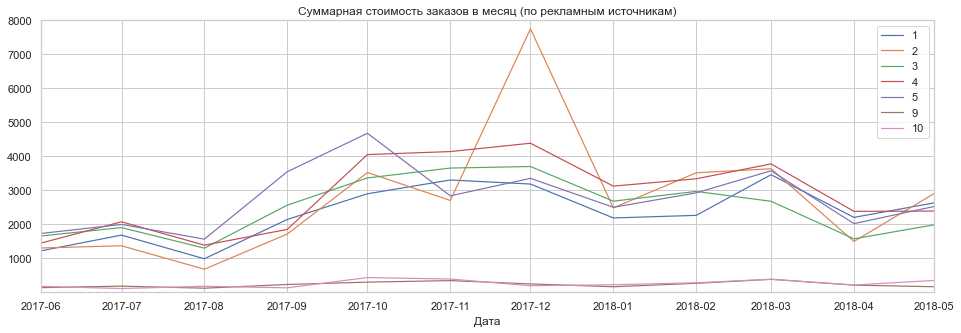

Средние метрики для пользователей с разных источников рекламы (в месяц):
   source_id sum_revenue number_of_orders average_revenue
0          1      2348.8            427.0             5.6
1          2      2758.3            384.9             6.7
2          3      2503.9            648.6             3.9
3          4      2644.2            665.4             4.0
4          5      2772.8            606.5             4.6
5          9       229.7             69.9             3.6
6         10       256.2             93.0             2.9


In [93]:
# рассмотрим параметры заказов в зависимости от рекламного источника пользователя
f, ax = plt.subplots(figsize=(16, 5))
f1, ax1 = plt.subplots(figsize=(16, 5))

columns_name = ['source_id', 'sum_revenue', 'number_of_orders', 'average_revenue']
content=[]

# вывод графиков в цикле и расчет средних характеристик для каждого из рекламных источников
for i in orders_visits['source_id'].sort_values().unique():
        orders_visits_source = orders_visits[orders_visits['source_id'] == i]\
                                     .pivot_table(index = 'order_month',
                                      values = 'revenue', 
                                      aggfunc = {'revenue':['sum', 'count', 'mean']}).reset_index()

        orders_visits_source.columns = ['order_month', 'number_of_orders','average_revenue','sum_revenue']
        
        ax.plot(orders_visits_source['order_month'], orders_visits_source['average_revenue'], linewidth = 1.2, label = i)
        ax.legend()
       
        ax1.plot(orders_visits_source['order_month'], orders_visits_source['sum_revenue'], linewidth = 1.2, label = i)
        ax1.legend()       
        content.append([i, '{:.1f}'.format(orders_visits_source['sum_revenue'].mean()),
                           '{:.1f}'.format(orders_visits_source['number_of_orders'].mean()),
                           '{:.1f}'.format(orders_visits_source['average_revenue'].mean())])
        
ax.set(xlabel = 'Дата', ylabel = '', title = 'Средний чек в месяц (по рекламным источникам)', 
       xlim = ('2017-06', '2018-05'), ylim = (2, 14))   

ax1.set(xlabel = 'Дата', ylabel = '', title = 'Суммарная стоимость заказов в месяц (по рекламным источникам)', 
       xlim = ('2017-06', '2018-05'), ylim = (2, 8000)) 
plt.show()

monthly_orders_visits_source = pd.DataFrame(content, columns = columns_name) 
print('Средние метрики для пользователей с разных источников рекламы (в месяц):')
print(monthly_orders_visits_source)

Средний чек больше всего для пользователей из рекламных источников 1 и 2. Количество заказов больше всего для источников 3, 4 и 5.

---

In [94]:
# суммарная выручка от пользователей, пользующихся сервисом с разных устройств
orders_visits.groupby('device')['revenue'].sum()

device
desktop    141921.38
touch       22891.77
Name: revenue, dtype: float64

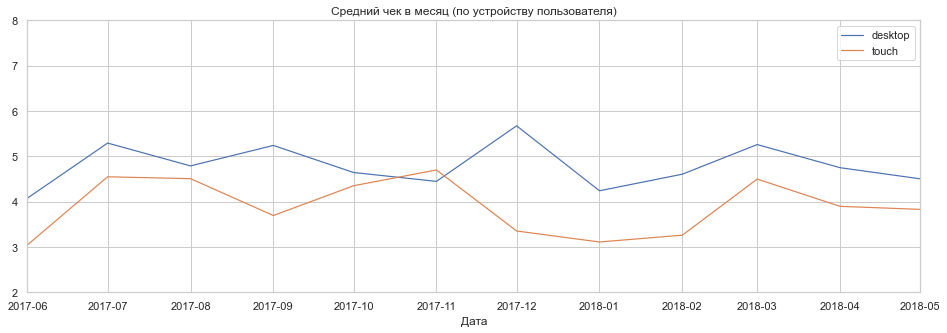

Средние метрики для пользователей с разными устройствами (в месяц):
  source_id sum_revenue number_of_orders average_revenue
0   desktop     10917.0           2269.6             4.7
1     touch      1907.6            492.0             3.9


In [95]:
# рассмотрим параметры заказов в зависимости от устройства пользователя
f, ax = plt.subplots(figsize=(16, 5))

columns_name = ['source_id', 'sum_revenue', 'number_of_orders', 'average_revenue']
content=[]

# вывод графиков в цикле и расчет средних характеристик для каждого из типов устройст
for i in orders_visits['device'].unique():
        orders_visits_device = orders_visits[orders_visits['device'] == i]\
                                     .pivot_table(index = 'order_month',
                                      values = 'revenue', 
                                      aggfunc = {'revenue':['sum', 'count', 'mean']}).reset_index()

        orders_visits_device.columns = ['order_month', 'number_of_orders','average_revenue','sum_revenue']
        ax.plot(orders_visits_device['order_month'], orders_visits_device['average_revenue'], linewidth = 1.2, label = i)
        ax.legend()
        
        content.append([i, '{:.1f}'.format(orders_visits_device['sum_revenue'].mean()),
                           '{:.1f}'.format(orders_visits_device['number_of_orders'].mean()),
                           '{:.1f}'.format(orders_visits_device['average_revenue'].mean())])   
        
ax.set(xlabel = 'Дата', ylabel = '', title = 'Средний чек в месяц (по устройству пользователя)', 
       xlim = ('2017-06', '2018-05'), ylim = (2, 8))        
plt.show() 

monthly_orders_visits_device = pd.DataFrame(content, columns = columns_name) 
print('Средние метрики для пользователей с разными устройствами (в месяц):')
print(monthly_orders_visits_device)

Средний чек для пользователей компьютера на 20% выше, чем у пользователей мобильных устройств. Количество заказов для пользователей компьютера в ~4,7 раза больше, и суммарная выручка больше в ~5,8 раз. 

## 4. Затраты на маркетинг
Рассмотрим расходы на рекламу, стоимость привлечения одного покупателя (CAC) и окупаемость маркетинговых вложений (ROMI).

### 4.1 Суммарные расходы

In [96]:
costs.head(3)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53


In [97]:
# выделим месяц трат в отдельный столбец
costs['costs_month'] = costs['dt'].astype('datetime64[M]')
costs.head(3)

,source_id,dt,costs,costs_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01


In [98]:
# сгруппируем таблицу по месяцу и найдём сумму трат
monthly_costs = costs.groupby('costs_month')['costs'].sum().round(1).reset_index()
monthly_costs

,costs_month,costs
0,2017-06-01,18015.0
1,2017-07-01,18240.6
2,2017-08-01,14790.5
3,2017-09-01,24368.9
4,2017-10-01,36322.9
5,2017-11-01,37907.9
6,2017-12-01,38315.4
7,2018-01-01,33518.5
8,2018-02-01,32723.0
9,2018-03-01,30415.3


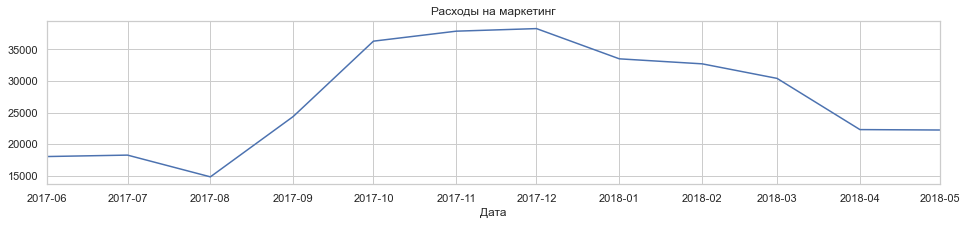

Всего потрачено 329131.6


In [99]:
f, ax = plt.subplots(figsize=(16, 3))
sns.lineplot(x = "costs_month", y = "costs", data = monthly_costs)
ax.set(xlabel = 'Дата', ylabel = '', title = 'Расходы на маркетинг', 
       xlim = ('2017-06', '2018-05'))
plt.show()

print('Всего потрачено', costs['costs'].sum().round(1))

Расходы на маркетинг были больше всего в октябре 2017 - январе 2018.

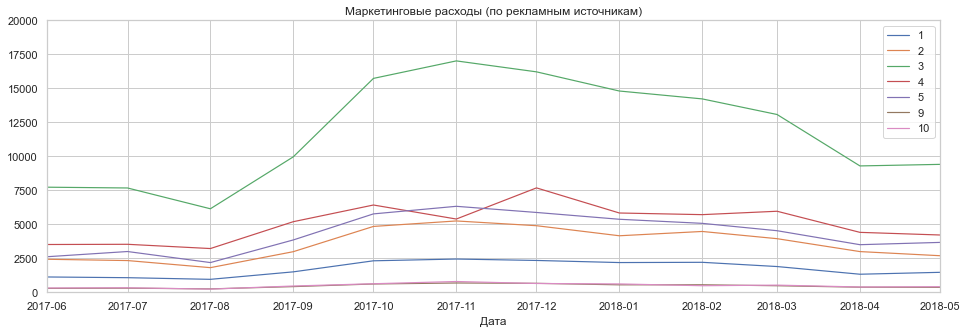

Суммарные расходы по источникам
   source_id      cost
0          1   20833.3
1          2   42806.0
2          3  141321.6
3          4   61073.6
4          5   51757.1
5          9    5517.5
6         10    5822.5


In [100]:
# рассмотрим траты на различные источники рекламы
f, ax = plt.subplots(figsize=(16, 5))

columns_name = ['source_id', 'cost']
content=[]

# вывод графиков в цикле и расчет средних характеристик для каждого из рекламных источников
for i in costs['source_id'].sort_values().unique():
        costs_source = costs[costs['source_id'] == i]\
                                     .pivot_table(index = 'costs_month',
                                      values = 'costs', 
                                      aggfunc = 'sum').reset_index()

        costs_source.columns = ['costs_month', 'monthly_costs']
        ax.plot(costs_source['costs_month'], costs_source['monthly_costs'], linewidth = 1.2, label = i)
        ax.legend()
        
        content.append([i, costs_source['monthly_costs'].sum().round(1)])
        
ax.set(xlabel = 'Дата', ylabel = '', title = 'Маркетинговые расходы (по рекламным источникам)', 
       xlim = ('2017-06', '2018-05'), ylim = (0, 20000))        
plt.show()

cost_source_overall = pd.DataFrame(content, columns = columns_name) 
print('Суммарные расходы по источникам')
print(cost_source_overall)

### 4.2 Стоимость привлечения покупателя

In [101]:
# количество покупателей, полученных с каждого рекламного источника
nubmer_of_users_source = orders_visits.groupby('source_id')['uid'].nunique().reset_index()
nubmer_of_users_source

,source_id,uid
0,1,4266
1,2,3650
2,3,7532
3,4,8148
4,5,6350
5,9,767
6,10,1077


In [102]:
# объединим наборы данных и вычислим, сколько стоило привлечение 1 покупателя из каждого источника
cac_source = pd.merge(cost_source_overall, nubmer_of_users_source, on = 'source_id')
cac_source['cac'] = (cac_source['cost']/ cac_source['uid']).round(2)
cac_source

,source_id,cost,uid,cac
0,1,20833.3,4266,4.88
1,2,42806.0,3650,11.73
2,3,141321.6,7532,18.76
3,4,61073.6,8148,7.50
4,5,51757.1,6350,8.15
5,9,5517.5,767,7.19
6,10,5822.5,1077,5.41


CAC (customer acquisition cost) - расходы на привлечение одного покупателя. Дороже всего обходится привлечение клиентов через каналы с id 2 и 3.

### 4.3 Возврат вложений

Сравним траты на маркетинг с полученной выручкой (суммарно и по месяцам).

In [103]:
# объединим столбцы с тратами по месяцам и стоимостью заказов по месяцам
monthly_costs_orders = pd.merge(orders_count, monthly_costs, 
                                left_on = 'order_month', 
                                right_on = 'costs_month')

In [104]:
orders.head(3)

,buy_ts,revenue,uid,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01


In [105]:
monthly_costs_orders = monthly_costs_orders[['order_month', 'sum_revenue', 'costs']]
monthly_costs_orders['order_month'] = monthly_costs_orders['order_month'].dt.strftime('%Y-%m')
monthly_costs_orders = monthly_costs_orders.rename(columns = {"order_month" : "month"})

Вычислим коэффициент ROMI как отношение выручки от заказов к маркетинговым раходам по месяцам.

In [106]:
monthly_costs_orders['romi'] = (monthly_costs_orders['sum_revenue']/monthly_costs_orders['costs']).round(2)

In [107]:
costs.head(3)

,source_id,dt,costs,costs_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01


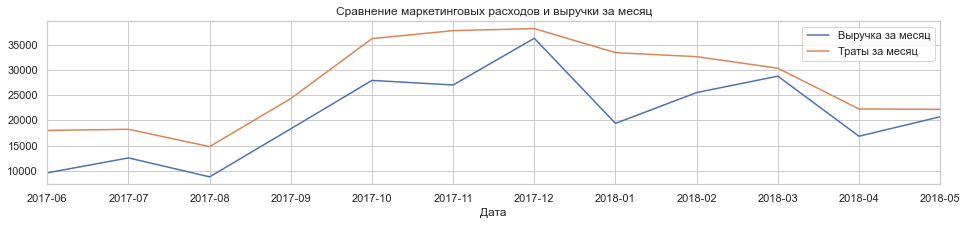

In [108]:
f, ax = plt.subplots(figsize=(16, 3))

sns.lineplot(x = "month", y = "sum_revenue", data = monthly_costs_orders, label = 'Выручка за месяц')
sns.lineplot(x = "month", y = "costs", data = monthly_costs_orders, label = 'Траты за месяц')

ax.set(xlabel = 'Дата', ylabel = '', 
       title = 'Сравнение маркетинговых расходов и выручки за месяц', 
       xlim = ('2017-06', '2018-05'))

plt.show()

В целом, в каждом месяце маркетинговые расходы больше, чем суммарная выручка от заказов.

---

Рассмотрим, как окупаются маркетинговые вложения по разным источникам рекламы.

In [109]:
print('Расходы и выручка по источникам')
source = pd.merge(orders_visits.groupby('source_id')['revenue'].sum().reset_index(), cost_source_overall, on = 'source_id')
source['romi'] = (source['revenue']/source['cost']).round(3)
source

Расходы и выручка по источникам


,source_id,revenue,cost,romi
0,1,28185.42,20833.3,1.353
1,2,33100.05,42806.0,0.773
2,3,30047.33,141321.6,0.213
3,4,34375.06,61073.6,0.563
4,5,33274.02,51757.1,0.643
5,9,2756.29,5517.5,0.500
6,10,3074.98,5822.5,0.528


Только рекламный источник ID 1 окупается и приносит прибыль, все остальные пока работают в минус.

In [110]:
print(monthly_costs_orders, '\n')
print('Общая выручка:', monthly_costs_orders['sum_revenue'].sum().round(1))
print('Общие траты:', monthly_costs_orders['costs'].sum().round(1))
print('Общий ROMI:', (monthly_costs_orders['sum_revenue'].sum()/ monthly_costs_orders['costs'].sum()).round(3))

      month  sum_revenue    costs  romi
0   2017-06      9557.49  18015.0  0.53
1   2017-07     12539.47  18240.6  0.69
2   2017-08      8758.78  14790.5  0.59
3   2017-09     18345.51  24368.9  0.75
4   2017-10     27987.70  36322.9  0.77
5   2017-11     27069.93  37907.9  0.71
6   2017-12     36388.60  38315.4  0.95
7   2018-01     19417.13  33518.5  0.58
8   2018-02     25560.54  32723.0  0.78
9   2018-03     28834.59  30415.3  0.95
10  2018-04     16858.06  22289.4  0.76
11  2018-05     20735.98  22224.3  0.93 

Общая выручка: 252053.8
Общие траты: 329131.7
Общий ROMI: 0.766


Каждый месяц траты на маркетинг превышают получаемую выручку и общий ROMI за год меньше 1 (полученная выручка меньше затрат), но к концу рассматриваемого периода размер выручки приближается к размеру трат. Проведем когортный анализ для выяснения подробностей.

### 4.4 Когортный анализ юнит-экономики

Вычислим LTV (lifetime value, суммарную выручку, которую приносит пользователь) по когортам. Для анализа LTV вернемся к начальному набору данных о всех заказах.

In [111]:
orders.head(3)

,buy_ts,revenue,uid,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01


In [112]:
# разделим пользователей на когорты по событию: месяц первого заказа
# для каждого пользователя выделим месяц его первого заказа
first_orders = orders.query('order_month < "2018-06-01"').groupby('uid')\
                     .agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
first_orders.head(3)

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01


In [113]:
# вычислим размер когорт - количество уникальных пользователей впервые совершавших покупки в разные месяцы
cohort_sizes = first_orders.groupby('first_order_month')\
                           .agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes

,first_order_month,n_buyers
0,2017-06-01,2022
1,2017-07-01,1922
2,2017-08-01,1369
3,2017-09-01,2579
4,2017-10-01,4340
5,2017-11-01,4078
6,2017-12-01,4380
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3534


In [114]:
# добавим месяц первого заказа для каждого uid
orders = pd.merge(orders, first_orders, on = 'uid')

In [115]:
# сгруппируем по месяцу заказа и месяцу первого заказа, вычислим сумму выручки
cohorts = orders.groupby(['first_order_month','order_month'])\
                .agg({'revenue': 'sum'}).reset_index()
cohorts.head(3)

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34


In [116]:
# добавим первоначальный размер для каждой когорты
report = pd.merge(cohort_sizes, cohorts, on = 'first_order_month')
report.head(3)

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2022,2017-06-01,9557.49
1,2017-06-01,2022,2017-07-01,981.82
2,2017-06-01,2022,2017-08-01,885.34


In [117]:
# для каждой когорты добавим возраст 
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

In [118]:
# промежуточный LTV найдём, как суммарную выручку от когорты в каждом месяце, отнесенную к размеру когорты
report['ltv'] = report['revenue'] / report['n_buyers']

# выведем промежуточный LTV каждого месяца существования каждой когорты 
output = report.pivot_table(index = 'first_order_month', 
                            columns = 'age', 
                            values = 'ltv', 
                            aggfunc = 'first').round(2)   
output.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.73,0.49,0.44,0.96,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,,
2017-09-01,5.65,1.12,0.52,3.98,0.4,0.65,0.7,0.24,0.18,,,
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,,,,
2017-11-01,5.16,0.4,0.2,0.33,0.15,0.05,0.12,,,,,
2017-12-01,4.74,0.26,0.93,1.07,0.31,0.34,,,,,,
2018-01-01,4.14,0.29,0.3,0.14,0.06,,,,,,,
2018-02-01,4.16,0.28,0.08,0.07,,,,,,,,


In [119]:
# добавим к таблице report данные о маркетинговых расходах в каждый месяц
report_new = pd.merge(report, monthly_costs, 
                      left_on = 'first_order_month', 
                      right_on = 'costs_month')

In [120]:
# рассчитаем стоимость привлечения одного клиента (CAC), 
# как отношение затрат на маркетинг к размеру соответствующей когорты
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new.head()

,first_order_month,n_buyers,order_month,revenue,age,ltv,costs_month,costs,cac
0,2017-06-01,2022,2017-06-01,9557.49,0,4.726751,2017-06-01,18015.0,8.909496
1,2017-06-01,2022,2017-07-01,981.82,1,0.485569,2017-06-01,18015.0,8.909496
2,2017-06-01,2022,2017-08-01,885.34,2,0.437854,2017-06-01,18015.0,8.909496
3,2017-06-01,2022,2017-09-01,1931.30,3,0.955143,2017-06-01,18015.0,8.909496
4,2017-06-01,2022,2017-10-01,2068.58,4,1.023037,2017-06-01,18015.0,8.909496


In [121]:
# вычислим промежуточное значение ROMI, как отношение LTV к CAC 
# для каждого месяца существования каждой когорты
report_new['romi'] = report_new['ltv'] / report_new['cac']

# окончательное значение ROMI вычислим как накопительную сумму промежуточных 
# значений для каждого месяца существования
output = report_new.pivot_table(index = 'first_order_month', 
                                columns = 'age', 
                                values = 'romi', 
                                aggfunc = 'first')

output.cumsum(axis=1).round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.7,0.74,0.77,0.78,,
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.3,1.38,1.4,1.42,,,
2017-10-01,0.60,0.66,0.68,0.7,0.72,0.74,0.75,0.76,,,,
2017-11-01,0.56,0.6,0.62,0.65,0.67,0.68,0.69,,,,,
2017-12-01,0.54,0.57,0.68,0.8,0.84,0.87,,,,,,
2018-01-01,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02-01,0.46,0.49,0.5,0.51,,,,,,,,


In [122]:
# найдём средний ROMI всех когорт для каждого месяца их существования
output.cumsum(axis=1).mean(axis=0).round(3)

age
0     0.541
1     0.582
2     0.631
3     0.720
4     0.783
5     0.860
6     0.897
7     0.970
8     1.054
9     0.964
10    1.095
11    1.334
dtype: float64

В среднем, когорты приближаются к окупаемости к концу 8-го месяца своего существования. В анализируемом наборе данных только 4 когорты из 12 существуют 8 и более месяцев, соответственно, все остальные когорты ещё не вернули затраты на своё привлечение, но ожидается, что сделают это в будущем.

---

Проведем когортный анализ для пользователей из разных рекламных каналов, чтобы посмотреть, как окупается каждый из каналов.

In [123]:
# найдём средние ROMI для месяцев существования когорт
# для пользователей с разными источниками рекламы

romi_source = pd.DataFrame([], columns = [])

# расчет средних характеристик для каждого из рекламных источников
for i in orders_visits['source_id'].sort_values().unique():
    orders_visits_source = orders_visits[orders_visits['source_id'] == i]
    
    # для каждого пользователя выделим месяц его первого заказа
    first_orders = orders_visits_source.query('order_month < "2018-06-01"').groupby('uid')\
                                       .agg({'order_month': 'min'}).reset_index()
    first_orders.columns = ['uid', 'first_order_month']
        
    # добавим месяц первого заказа для каждого uid
    orders_visits_source = pd.merge(orders_visits_source, first_orders, on = 'uid')
    
    # разделим пользователей на когорты по событию: месяц первого заказа
    # вычислим размер когорт - количество уникальных пользователей впервые совершавших покупки в разные месяцы
    cohort_sizes = first_orders.groupby('first_order_month')\
                               .agg({'uid': 'nunique'}).reset_index()
    cohort_sizes.columns = ['first_order_month', 'n_buyers']
        
    # сгруппируем по месяцу заказа и месяцу первого заказа, вычислим сумму выручки
    cohorts = orders_visits_source.groupby(['first_order_month','order_month'])\
                                  .agg({'revenue': 'sum'}).reset_index()
    
    # добавим первоначальный размер для каждой когорты
    report = pd.merge(cohort_sizes, cohorts, on = 'first_order_month')
    
    # для каждой когорты добавим возраст 
    report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
    report['age'] = report['age'].round().astype('int')


    # промежуточный LTV найдём, как суммарную выручку от когорты в каждом месяце, отнесенную к размеру когорты
    report['ltv'] = report['revenue'] / report['n_buyers']
    report['first_order_month'] = report['first_order_month']

    # траты по месяцам на выбранный источник
    costs_source = costs[costs['source_id'] == i].pivot_table(
                                                 index = 'costs_month',
                                                 values = 'costs', 
                                                 aggfunc = 'sum').reset_index()

    costs_source.columns = ['costs_month', 'monthly_costs']
    
    # добавим к таблице report данные о маркетинговых расходах каждый месяц
    report_new = pd.merge(report, costs_source, left_on = 'first_order_month', 
                                                right_on = 'costs_month')

    # рассчитаем стоимость привлечения одного клиента CAC, 
    # как отношение затрат на маркетинг к размеру соответствующей когорты
    report_new['cac'] = report_new['monthly_costs'] / report_new['n_buyers']

    # вычислим промежуточное значение ROMI, как отношение LTV к CAC для каждого месяца существования каждой когорты
    report_new['romi'] = report_new['ltv'] / report_new['cac']

    # окончательное значение ROMI вычислим как последовательную сумму промежуточных значений 
    # для каждого следующего месяца существования
    output = report_new.pivot_table(index = 'first_order_month', 
                                    columns = 'age', 
                                    values = 'romi', 
                                    aggfunc = 'first')

    romi_source = romi_source.append(output.cumsum(axis=1).mean(axis=0).round(3), ignore_index = True)  

romi_source['source_id'] = orders_visits['source_id'].sort_values().unique()
print('Средний ROMI каждого месяца существования когорты (по источникам)')
romi_source        

Средний ROMI каждого месяца существования когорты (по источникам)


,0,1,2,3,4,5,6,7,8,9,10,11,source_id
0,1.067,1.157,1.188,1.226,1.296,1.404,1.557,1.631,1.733,1.961,2.354,2.705,1
1,0.486,0.575,0.643,0.728,0.798,0.879,0.815,0.697,0.734,0.646,0.724,0.662,2
2,0.210,0.212,0.219,0.223,0.218,0.231,0.233,0.230,0.240,0.259,0.238,0.218,3
3,0.535,0.541,0.567,0.545,0.546,0.549,0.544,0.482,0.469,NaN,0.429,0.435,4
4,0.602,0.618,0.639,0.643,0.671,0.714,0.757,0.874,0.866,0.915,0.925,0.991,5
5,0.467,0.508,0.577,0.477,0.547,0.513,0.687,NaN,0.525,0.525,0.553,NaN,9
6,0.543,0.545,0.496,0.697,0.697,0.498,0.500,NaN,NaN,NaN,NaN,NaN,10


Затраты на привлечение пользователей через рекламный источник с ID 1, окупаются уже в первый месяц, а через год окупаются более чем в 2.5 раза. Пользователи, привлекаемые через рекламный источник 5, через год почти полностью возвращают затраты на своё привлечение. Все остальные рекламные источники, по крайней мере в этой выборке данных, далеки от окупаемости.

## 5. Выводы. Рекомендации для маркетологов

Рекламный источник:
- больше всего средств было вложено в источник с ID 3 (как минимум в 2 раза больше, чем в любой другой);
- суммарная выручка за год больше всего для ID 2, 4, 5; немного меньше для ID 1 и 3; и по крайней мере в 10 раз меньше для ID 9 и 10;
- с точки зрения окупаемости выгоднее всего рекламные источники ID 1 и 5.

Платформа: 
- пользователи активнее посещают сайт с компьютера (примерно в 2,8 раза больше посещений и в 1,5 раза более длинные сессии);
- с наступлением зимы, пользователи активнее заходят на сайт с компьютера;
- но на выходных и праздниках пользователи активнее заходят на сайт с мобильных устройств;
- в итоге пользователи компьютера приносят примерно в 6.3 раз больше выручки, чем пользователи мобильных устройств;

Исходя из этого, стоит ориентироваться на пользователей десктопной версии и пользователей, приходящих с источников 1 и 5.